In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.version.VERSION)

2.3.0


In [2]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#Importing files and defining dimension of image

width=256
height=256
channels=3

import tensorflow as tf
import os
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.transform import resize
import matplotlib.pyplot as plt
from load_data import load_path, get_data, shuffling

seed=42
np.random.seed=seed

In [4]:
#Defining path and getting ids of images
train_path='Augmented_Preprocessed/Train/Image'
train_mask_path='Augmented_Preprocessed/Train/Mask'
test_path='Preprocessed/Test/Image'
test_mask_path='Preprocessed/Test/Mask'

train_ids, train_mask_ids, test_ids, test_mask_ids = load_path(train_path, train_mask_path, test_path, test_mask_path)

In [5]:
#loding train and test images and randomly shuffling it
X_train, Y_train = get_data(train_path, train_mask_path, train_ids, train_mask_ids, height, width)
X_test, Y_test = get_data(test_path, test_mask_path, test_ids, test_mask_ids, height, width)
X_train, Y_train = shuffling(X_train, Y_train)
X_test, Y_test = shuffling(X_test, Y_test)

100%|██████████| 20/20 [00:00<00:00, 169.24it/s]


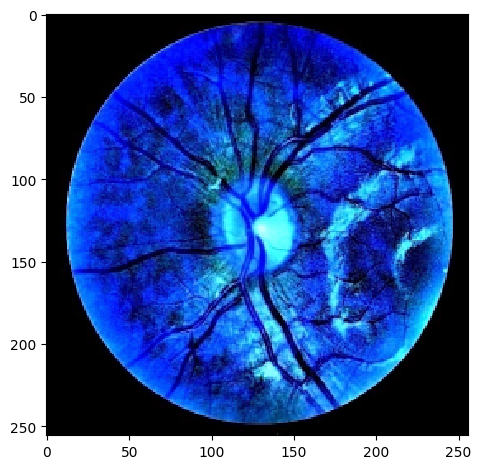

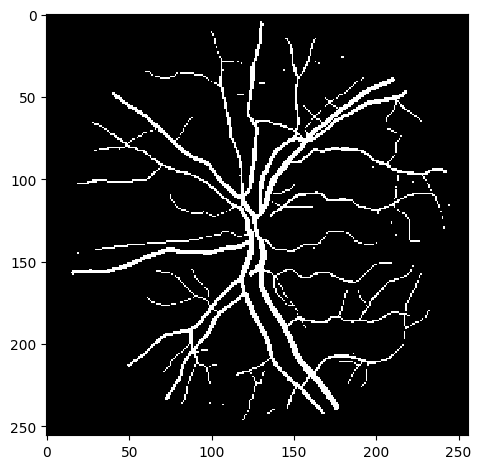

In [6]:
#testing train
img_x=random.randint(0, len(train_ids))
imshow(X_train[img_x])
plt.show()
imshow(Y_train[img_x])
plt.show()

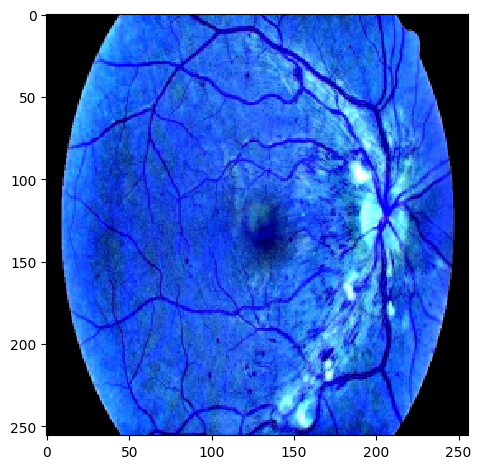

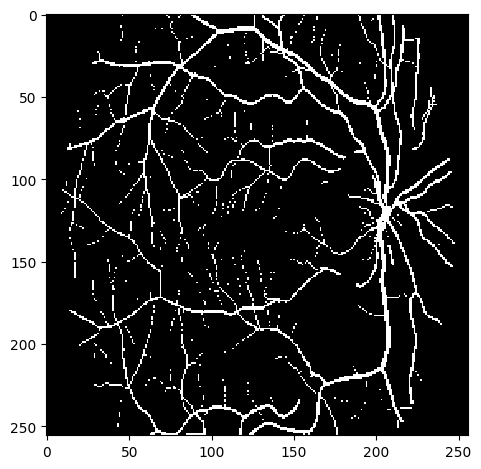

In [7]:
#testing test
img_x=random.randint(0, len(test_ids))
imshow(X_test[img_x])
plt.show()
imshow(Y_test[img_x])
plt.show()

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from Metrics import dice_coef, dice_loss, iou

In [9]:
#Defining parameters
batch_size = 16
lr = 1e-3
num_epochs = 20
model_path = os.path.join('vggpreprocessed.h5')
csv_path = os.path.join('vggpreprocessed.csv')

In [10]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

In [11]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    return x

In [12]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [13]:
def build_vgg16_unet(input_shape):
    inputs = Input(input_shape)
    
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
    vgg16.trainable = False
    
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """ 
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="VGG16_U-Net")  
    return model

In [14]:
input_shape = (height, width, 3)
model = build_vgg16_unet(input_shape)
model.compile(optimizer=Adam(lr), loss=dice_loss, metrics=[dice_coef, iou, Accuracy(), Recall(), Precision()])
model.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
________________________________________________________________________________________

In [15]:
#Model Checkpoint
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_retina', verbose=1,save_best_only=True)

callbacks=[
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    CSVLogger(csv_path),
]

results=model.fit(X_train, Y_train, validation_split = 0.1, batch_size = batch_size, epochs = num_epochs, callbacks=callbacks)

Epoch 1/20
  1/395 [..............................] - ETA: 0s - loss: 0.8677 - dice_coef: 0.1323 - iou: 0.0709 - accuracy: 0.0000e+00 - recall: 0.4810 - precision: 0.0738WARNING:tensorflow:From C:\Users\User\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
395/395 [==============================] - ETA: 0s - loss: 0.2975 - dice_coef: 0.7026 - iou: 0.5496 - accuracy: 0.0240 - recall: 0.7651 - precision: 0.6763
Epoch 00001: val_loss improved from inf to 0.23538, saving model to vggpreprocessed.h5
395/395 [==============================] - 260s 659ms/step - loss: 0.2975 - dice_coef: 0.7026 - iou: 0.5496 - accuracy: 0.0240 - recall: 0.7651 - precision: 0.6763 - val_loss: 0.2354 - val_dice_coef: 0.7647 - val_iou: 0.6192 - val_accuracy: 0.0381 - val_recall: 0.7831 - val_precision: 0.7618


Epoch 15/20
395/395 [==============================] - ETA: 0s - loss: 0.1749 - dice_coef: 0.8250 - iou: 0.7023 - accuracy: 0.0594 - recall: 0.8199 - precision: 0.8310
Epoch 00015: val_loss improved from 0.18641 to 0.18547, saving model to vggpreprocessed.h5
395/395 [==============================] - 262s 663ms/step - loss: 0.1749 - dice_coef: 0.8250 - iou: 0.7023 - accuracy: 0.0594 - recall: 0.8199 - precision: 0.8310 - val_loss: 0.1855 - val_dice_coef: 0.8146 - val_iou: 0.6874 - val_accuracy: 0.0608 - val_recall: 0.8276 - val_precision: 0.8025
Epoch 16/20
395/395 [==============================] - ETA: 0s - loss: 0.1734 - dice_coef: 0.8265 - iou: 0.7044 - accuracy: 0.0597 - recall: 0.8213 - precision: 0.8325
Epoch 00016: val_loss did not improve from 0.18547
395/395 [==============================] - 257s 652ms/step - loss: 0.1734 - dice_coef: 0.8265 - iou: 0.7044 - accuracy: 0.0597 - recall: 0.8213 - precision: 0.8325 - val_loss: 0.1871 - val_dice_coef: 0.8130 - val_iou: 0.6851 - va

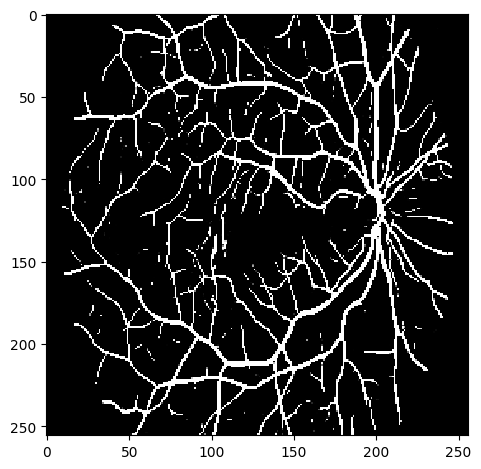

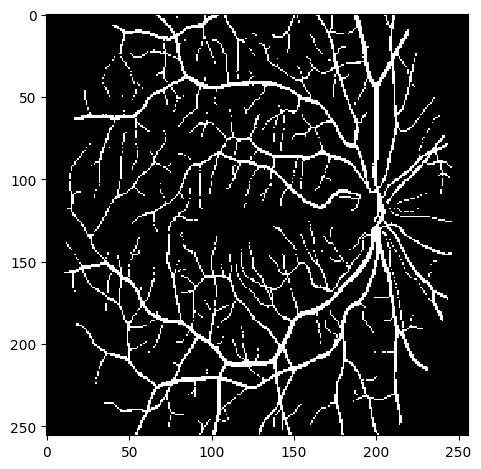

In [16]:
Y_pred = model.predict(X_test)
imshow(Y_pred[11])
plt.show()
imshow(Y_test[11])
plt.show()

In [17]:
results = model.evaluate(X_test, Y_test, verbose=1)
print(results)

1/1 [==============================] - 0s 4ms/step - loss: 0.2155 - dice_coef: 0.7845 - iou: 0.6454 - accuracy: 0.0673 - recall: 0.7793 - precision: 0.7905
[0.21548032760620117, 0.7845196723937988, 0.6454400420188904, 0.06731109321117401, 0.7793423533439636, 0.7905455827713013]


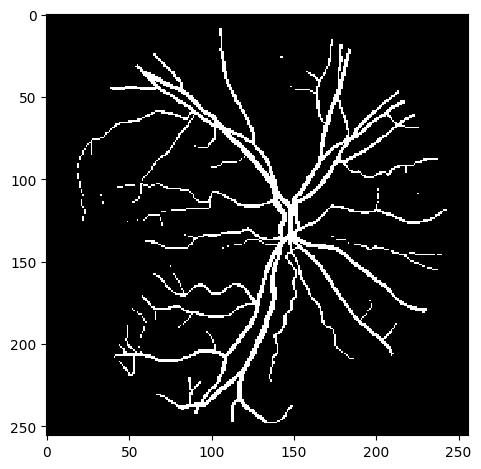

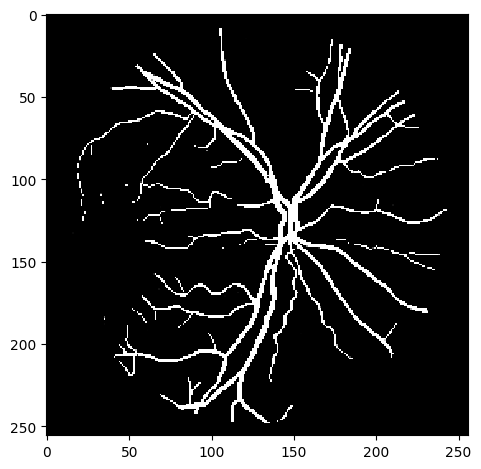

In [24]:
Y_pred = model.predict(X_train)
imshow(Y_train[20])
plt.show()
imshow(Y_pred[20])
plt.show()